In [1]:
from circuit_knitting.cutting import partition_problem
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.quantum_info import SparsePauliOp, PauliList
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from qiskit_algorithms.optimizers.cobyla import COBYLA
from qiskit.algorithms.optimizers import ADAM, SPSA
from qiskit_algorithms.utils import algorithm_globals
from IPython.display import clear_output
from accuracy_score import encode_y
import time

/tmp/ipykernel_55040/4071736489.py:9: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed in Qiskit 1.0. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import ADAM, SPSA


In [2]:
seed = 100

## Data Loading

In [3]:
# Load data
data = pd.read_csv("diabetes_normalized.csv")
data = data.drop(["Unnamed: 0"], axis=1)
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-0.923998,1.531329,0.566517,-0.920265,-3.141593,0.004682,-1.66872,-0.104720,1
1,-2.771994,-0.457820,0.257508,-1.301064,-3.141593,-0.650792,-2.40918,-2.094395,0


In [4]:
y = data["Outcome"]
x = data.drop(["Outcome"], axis=1)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(537, 8) (537,) (231, 8) (231,)


In [6]:
x_train_A = x_train.iloc[:, :4]
x_train_B = x_train.iloc[:, 4:]

In [7]:
x_test_A = x_test.iloc[:, :4]
x_test_B = x_test.iloc[:, 4:]

In [8]:
new_y_train = encode_y(y_train)
new_y_test = encode_y(y_test)

## Data Embedding

In [9]:
# Data Embedding - Angle Encoding
def angle_encoding(feature_dims: int):
    embedding = QuantumCircuit(feature_dims)
    feature_param = ParameterVector("Theta", feature_dims)
    for qubit in range(feature_dims):
        embedding.ry(feature_param[qubit], qubit)
    return embedding, feature_param

In [10]:
embedding, feature_params = angle_encoding(4)

## Tensor Network

In [11]:
from ttn import TTN

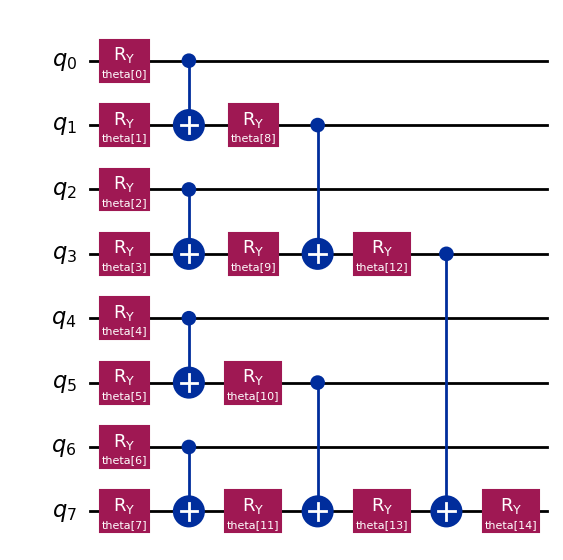

In [12]:
ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
ttn.draw("mpl", style="iqp")

In [13]:
# ttn.parameters

## Circuit Cutting

In [14]:
observables = PauliList(["ZIIIIIII"])
partitioned_problem = partition_problem(circuit=ttn, partition_labels="AAAABBBB", observables=observables)
sub_circuits = partitioned_problem.subcircuits
sub_observables = partitioned_problem.subobservables
bases = partitioned_problem.bases

In [15]:
sub_observables

{'A': PauliList(['IIII']), 'B': PauliList(['ZIII'])}

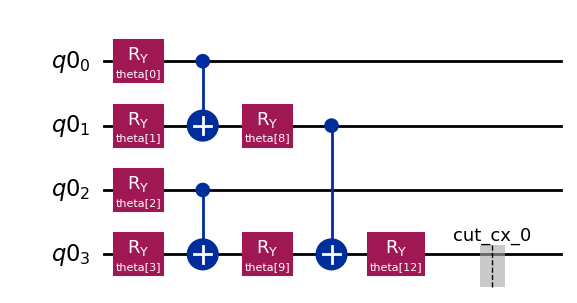

In [16]:
sub_circuits["A"].draw("mpl", style="iqp")

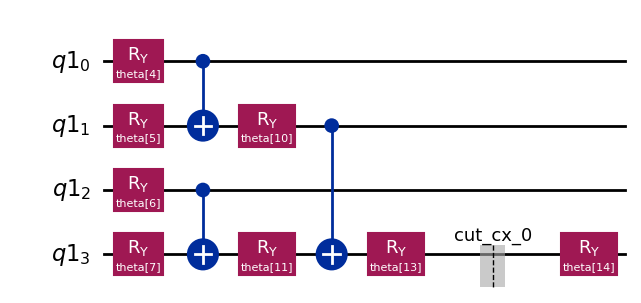

In [17]:
sub_circuits["B"].draw("mpl", style="iqp")

In [18]:
print(f"Sampling overhead: {np.prod([basis.overhead for basis in bases])}")

Sampling overhead: 9.0


### Sub Experiments

In [19]:
from circuit_knitting.cutting import generate_cutting_experiments

subexperiments, coefficients = generate_cutting_experiments(
    circuits=sub_circuits, observables=sub_observables, num_samples=np.inf
)

In [20]:
# subexperiments
len(subexperiments["A"])

6

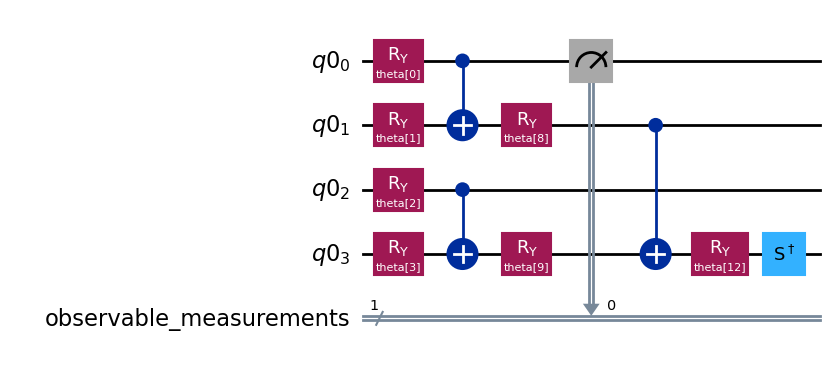

In [21]:
subexperiments["A"][0].draw("mpl", style="iqp")

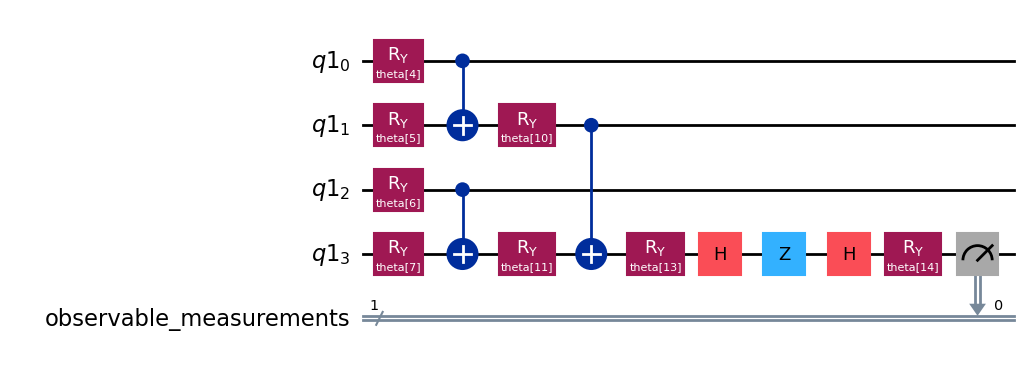

In [22]:
subexperiments["B"][3].draw("mpl", style="iqp")

## Neural Network Training

In [23]:
from qiskit_machine_learning.neural_networks import SamplerQNN, NeuralNetwork
from qiskit_aer.primitives import Sampler
from qiskit_aer import AerSimulator
from typing import Callable

In [24]:
gpu_sim = AerSimulator(device="GPU", cuStateVec_enable=False)
# gpu_sim = AerSimulator(device="GPU", cuStateVec_enable=True)
gpu_sim.available_devices()

('CPU', 'GPU')

In [25]:
sampler = Sampler(backend_options={"simulator": gpu_sim})
# sampler = Sampler(backend_options={"simulator": gpu_sim}, transpile_options={"optimization_level": 3}, run_options={"shots": 1024})
# sampler = Sampler(backend_options={"simulator": gpu_sim})

### Sampler

In [26]:
from custom_sampler_qnn import CustomSampler

#### For subexperiments["A"]

In [27]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]
# final_circuits[0].draw("mpl")

In [28]:
sampler_qcnn = CustomSampler(
    circuits=final_circuits, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["A"].parameters,
    input_gradients=False,
)

In [ ]:
weights_A = algorithm_globals.random.random(7)
forward_output = sampler_qcnn.forward(
    input_data=x_train_A,
    weights=weights_A,
)

In [ ]:
# forward output is a dictionary of 6 subex_circ items.
print(f"Output shape for {len(x_train_A)} samples: {forward_output[0].shape}")
print(len(forward_output[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output[i][0] for i in range(6)])}")

In [ ]:
input_grad, weights_grad = sampler_qcnn.backward(
    input_data=x_train_A,
    weights=weights_A
)

In [ ]:
print(f"Output shape for {len(x_train_A)} samples: {weights_grad[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad[i][0] for i in range(6)])}")

#### For subexperiments["B"]

In [29]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [30]:
sampler_qcnn2 = CustomSampler(
    circuits=final_circuits2, 
    sampler=sampler,
    input_params=feature_params.params,
    weight_params=sub_circuits["B"].parameters,
)

In [ ]:
weights_B = algorithm_globals.random.random(8)
forward_output2 = sampler_qcnn2._forward(
    input_data=x_train_B,
    weights=weights_B,
)

In [ ]:
print(f"Output shape for {len(x_train_A)} samples: {forward_output2[0].shape}")
print(len(forward_output2[0]))
print(f"Output of the forward pass for first sample: \n{np.array([forward_output2[i][0] for i in range(6)])}")

In [ ]:
input_grad2, weights_grad2 = sampler_qcnn2._backward(
    input_data=x_train_B,
    weights=weights_B
)

In [ ]:
print(f"Output shape for {len(x_train_B)} samples: {weights_grad2[0].shape}")
print(f"Output of the backward pass for first sample for first subexperiment circuit: \n{np.array([weights_grad2[i][0] for i in range(6)])}")

## Loss and Optimization

In [31]:
from qiskit_machine_learning.utils.loss_functions import L2Loss
from qiskit_algorithms.optimizers import COBYLA, SPSA, GradientDescent
from custom_cross_entropy_loss import CustomCrossEntropyLoss
from objective_func import CustomMultiClassObjectiveFunction
# from loss_optimization.callback import callback
from optimization import create_objective, minimizer, print_optimizer_results

In [32]:
def callback_spsa(nfev=None, params=None, fval=None, stepsize=None, accepted=None):
    """
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    # objective_func_vals = loss
    global objective_func_vals

    if (nfev % 3) == 0:
        objective_func_vals.append(fval)
        print(f"SPSA Epoch {len(objective_func_vals)}: {fval:.5f}")

def callback_cobyla(weights, obj_func_eval):
    # clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    print(f"COBYLA Epoch {len(objective_func_vals)}: {obj_func_eval:.5f}")

In [33]:
objective_func_vals = []
# loss = L2Loss()
loss = CustomCrossEntropyLoss()
# optimizer = COBYLA(maxiter=5)
optimizer = SPSA(maxiter=50, callback=callback_spsa)
# optimizer = GradientDescent(maxiter=2) # This doesn't work yet. The gradient shape doesn't match.

#### Optimizer Result for sub-circuits["A"]

In [34]:
initial_point = np.random.random((7,))
function = CustomMultiClassObjectiveFunction(x_train_A, y_train.values, sampler_qcnn, loss)

In [35]:
# Optimizer result for 0th circuit for sub-circuit-A
start_time = time.time()
optimizer_result_A0 = minimizer(function, function.objective0, function.gradient0, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A1: %s seconds", running_time)

start_time = time.time()
optimizer_result_A1 = minimizer(function, function.objective1, function.gradient1, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A2: %s seconds", running_time)

start_time = time.time()
optimizer_result_A2 = minimizer(function, function.objective2, function.gradient2, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A3: %s seconds", running_time)

start_time = time.time()
optimizer_result_A3 = minimizer(function, function.objective3, function.gradient3, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A4: %s seconds", running_time)

start_time = time.time()
optimizer_result_A4 = minimizer(function, function.objective4, function.gradient4, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A5: %s seconds", running_time)

start_time = time.time()
optimizer_result_A5 = minimizer(function, function.objective5, function.gradient5, initial_point, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-A6: %s seconds", running_time)

Running Time for Forward Pass: %s seconds 4.550413608551025
Running Time for Forward Pass: %s seconds 3.526160478591919
Running Time for Forward Pass: %s seconds 4.077063798904419
Running Time for Forward Pass: %s seconds 3.7208340167999268
Running Time for Forward Pass: %s seconds 3.924011707305908
Running Time for Forward Pass: %s seconds 3.5359976291656494
Running Time for Forward Pass: %s seconds 3.921128749847412
Running Time for Forward Pass: %s seconds 3.479431390762329
Running Time for Forward Pass: %s seconds 4.113738536834717
Running Time for Forward Pass: %s seconds 4.06843376159668
Running Time for Forward Pass: %s seconds 3.912919759750366
Running Time for Forward Pass: %s seconds 4.198209524154663
Running Time for Forward Pass: %s seconds 3.6995625495910645
Running Time for Forward Pass: %s seconds 4.10276198387146
Running Time for Forward Pass: %s seconds 3.9062325954437256
Running Time for Forward Pass: %s seconds 4.1113057136535645
Running Time for Forward Pass: %s sec

In [36]:
optimizer_results_A = [optimizer_result_A0, optimizer_result_A1, optimizer_result_A2, optimizer_result_A3, optimizer_result_A4, optimizer_result_A5]

In [37]:
# Print results from 6 sub-experiments of sub-circuit-A
for opt_result in optimizer_results_A:
    print_optimizer_results(opt_result)

New params (The final point of the minimization): [-1.11014823  0.92306064  1.23722863 -0.80420931 -1.29109566 -0.03841404
  1.40905931]
The final value of the minimization: 3.0913295865871553
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-1.10533164  0.24947969 -0.88592139  1.45771135 -0.23893304 -0.71210416
  0.13935035]
The final value of the minimization: 3.0892023770989225
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-1.12018245  0.02255229  1.62924039  0.45615453  0.57422933 -0.07941653
 -1.28125282]
The final value of the minimization: 0.39620590757628343
The final gradient of the minimization: None
The total number of function 

Text(0.5, 1.0, 'Training loss')

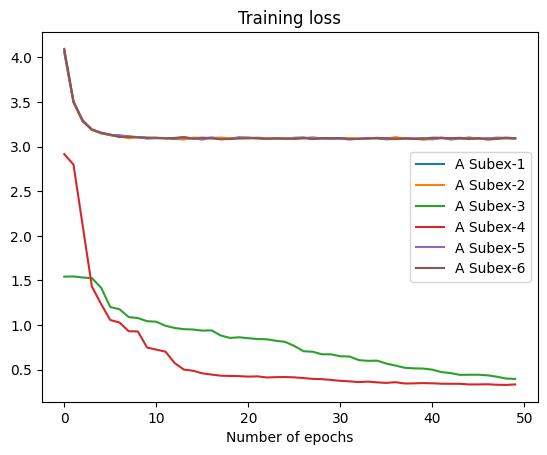

In [43]:
plt.plot(objective_func_vals[:50], label="A Subex-1")
plt.plot(objective_func_vals[50:100], label="A Subex-2")
plt.plot(objective_func_vals[100:150], label="A Subex-3")
plt.plot(objective_func_vals[150:200], label="A Subex-4")
plt.plot(objective_func_vals[200:250], label="A Subex-5")
plt.plot(objective_func_vals[250:300], label="A Subex-6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [44]:
objective_func_vals.clear()
objective_func_vals

[]

#### Optimizer Result for sub-circuits["B"]

In [45]:
initial_point2 = np.random.random((8,))
function2 = CustomMultiClassObjectiveFunction(x_train_B, y_train, sampler_qcnn2, loss)

In [46]:
# Optimizer result for 0th circuit for sub-circuit-B
start_time = time.time()
optimizer_result_B0 = minimizer(function2, function2.objective0, function2.gradient0, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B1: %s seconds", running_time)

start_time = time.time()
optimizer_result_B1 = minimizer(function2, function2.objective1, function2.gradient1, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B1: %s seconds", running_time)

start_time = time.time()
optimizer_result_B2 = minimizer(function2, function2.objective2, function2.gradient2, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B1: %s seconds", running_time)

start_time = time.time()
optimizer_result_B3 = minimizer(function2, function2.objective3, function2.gradient3, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B1: %s seconds", running_time)

start_time = time.time()
optimizer_result_B4 = minimizer(function2, function2.objective4, function2.gradient4, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B1: %s seconds", running_time)

start_time = time.time()
optimizer_result_B5 = minimizer(function2, function2.objective5, function2.gradient5, initial_point2, optimizer)
end_time = time.time()
running_time = end_time - start_time
print("Running Time for optimizing Subex-B1: %s seconds", running_time)

Running Time for Forward Pass: %s seconds 5.459405422210693
Running Time for Forward Pass: %s seconds 6.521866083145142
Running Time for Forward Pass: %s seconds 4.806445121765137
Running Time for Forward Pass: %s seconds 5.147233963012695
Running Time for Forward Pass: %s seconds 4.875425815582275
Running Time for Forward Pass: %s seconds 8.724041938781738
Running Time for Forward Pass: %s seconds 4.615893602371216
Running Time for Forward Pass: %s seconds 4.771284580230713
Running Time for Forward Pass: %s seconds 4.6619908809661865
Running Time for Forward Pass: %s seconds 4.662001132965088
Running Time for Forward Pass: %s seconds 4.802353620529175
Running Time for Forward Pass: %s seconds 6.391260623931885
Running Time for Forward Pass: %s seconds 5.2342119216918945
Running Time for Forward Pass: %s seconds 8.029057502746582
Running Time for Forward Pass: %s seconds 4.7944066524505615
Running Time for Forward Pass: %s seconds 6.253872394561768
Running Time for Forward Pass: %s sec

In [47]:
optimizer_results_B = [optimizer_result_B0, optimizer_result_B1, optimizer_result_B2, optimizer_result_B3, optimizer_result_B4, optimizer_result_B5]

In [48]:
# Print results from 6 sub-experiments of sub-circuit-B
for opt_result in optimizer_results_B:
    print_optimizer_results(opt_result)

New params (The final point of the minimization): [ 0.17846638  1.88519386  0.3996674   0.6364267   1.97488688 -0.03408613
 -0.00463664 -1.56876545]
The final value of the minimization: 2.710236783725476
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-1.24827867  0.96563892  1.87530222  0.49709338 -0.58313121  0.16524993
 -0.05259048 -1.59351331]
The final value of the minimization: 2.726846207305318
The final gradient of the minimization: None
The total number of function evaluations: 150
The total number of gradient evaluations: None
The total number of iterations: 50
New params (The final point of the minimization): [-0.17625114 -0.87154108 -0.74224826  0.48833692  1.0491028  -0.14682407
 -1.24694847 -0.39887112]
The final value of the minimization: 2.696657022144027
The final gradient of the minimization: No

Text(0.5, 1.0, 'Training loss')

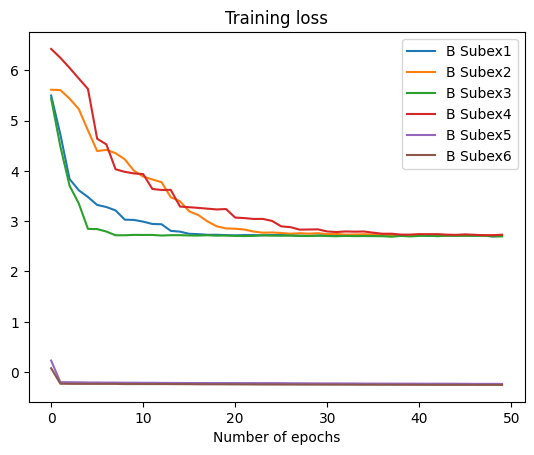

In [53]:
plt.plot(objective_func_vals[:50], label="B Subex1")
plt.plot(objective_func_vals[50:100], label="B Subex2")
plt.plot(objective_func_vals[100:150], label="B Subex3")
plt.plot(objective_func_vals[150:200], label="B Subex4")
plt.plot(objective_func_vals[200:250], label="B Subex5")
plt.plot(objective_func_vals[250:300], label="B Subex6")
plt.legend()
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
objective_func_vals.clear()
objective_func_vals

### At this point, the training is complete. 
We have 12 lists of 7 or 8 parameter values that will now be used to make predictions on the test cases. 
New subcircuits will be built using these parameter values and then their results will be used to reconstruct expectation values. This process will occur for all the inputs in the test set.


Let us think of the training process as a box that we can tune/edit while training on the train set. However, once the training process is complete, the box is locked and provided to the user. The user can now send test data to the box and get its desired output.

However, in the case of circuit cutting, instead of having one box, we have multiple boxes. In our case, we have a total of 12 boxes (6 boxes per cut). These 12 boxes are trained independently of each other and locked after the training process is complete. The user, now, instead of sending the test data to one box, splits it into 2 parts that are sent to these 12 boxes. The 12 boxes produce quasi-probability distributions respective to the circuits they implement which are then reconstructed to produce the expectation value according to the test input. This process is repeated for every data point in the test dataset.

## Reconstruct Expectation Values and Testing

In [54]:
from circuit_knitting.cutting import reconstruct_expectation_values
from qiskit_aer.primitives import Sampler
from qiskit.primitives import SamplerResult
from accuracy_score import get_accuracy_score, predict
from reconstruct_exp_val import get_subcircuit_results, get_dict_sampler_results, get_reconstructed_expvals

### Reconstructing for train accuracy

In [ ]:
final_circuits = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["A"]]

In [ ]:
final_circuits2 = [embedding.compose(subex_circuit, inplace=False) for subex_circuit in subexperiments["B"]]

In [55]:
train_results_A = get_subcircuit_results(x_train_A, final_circuits, optimizer_results_A, sampler)
train_results_B = get_subcircuit_results(x_train_B, final_circuits2, optimizer_results_B, sampler)

In [56]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 537 train data inputs
A_dict = get_dict_sampler_results(x_train_A, subexperiments["A"], train_results_A)
B_dict = get_dict_sampler_results(x_train_B, subexperiments["B"], train_results_B)

In [57]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [58]:
y_predicted = predict(reconstructed_expvals)

In [59]:
# accuracy_score function encodes y_train inside the function. Therefore, pass original y_train here.
train_score1 = get_accuracy_score(new_y_train, y_predicted)
train_score2 = get_accuracy_score(y_train, y_predicted)
print(f"The Train Accuracy of the model is: {train_score1, train_score2}")

The Train Accuracy of the model is: (0.6517690875232774, 0.6517690875232774)


### Reconstructing for test accuracy

In [60]:
test_results_A = get_subcircuit_results(x_test_A, final_circuits, optimizer_results_A, sampler)
test_results_B = get_subcircuit_results(x_test_B, final_circuits2, optimizer_results_B, sampler)

In [61]:
# Dict of SamplerResults of 6 sub-circuits A and B for each 231 test data inputs
A_dict = get_dict_sampler_results(x_test_A, subexperiments["A"], test_results_A)
B_dict = get_dict_sampler_results(x_test_B, subexperiments["B"], test_results_B)

In [62]:
reconstructed_expvals = get_reconstructed_expvals(A_dict, B_dict, coefficients, sub_observables)

In [63]:
y_predicted = predict(reconstructed_expvals)

In [64]:
# Pass original y_test here.
test_score1 = get_accuracy_score(new_y_test, y_predicted)
test_score2 = get_accuracy_score(y_test, y_predicted)
print(f"The Test Accuracy of the model is: {test_score1, test_score2}")

The Test Accuracy of the model is: (0.645021645021645, 0.645021645021645)


## Test original circuit

In [97]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkClassifier
from qiskit.primitives import BackendEstimator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Estimator
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss

In [98]:
embedding, features = angle_encoding(8)
new_ttn = TTN(num_qubits=8).ttn_simple(complex_structure=False)
org_circuit = embedding.compose(new_ttn)
# final_circuit.draw()

In [99]:
gpu_simulator = AerSimulator(device='GPU')
backend = Estimator(backend_options={"simulator": gpu_simulator}, transpile_options={"optimization_level": 3})

In [100]:
observable = SparsePauliOp(["ZIIIIIII"])
estimator_qnn = EstimatorQNN(
    estimator=backend,
    circuit=org_circuit,
    observables=observable,
    input_params=features.params,
    weight_params=new_ttn.parameters,
)

In [101]:
weights = np.random.random(len(new_ttn.parameters))

In [102]:
# Forward pass
output = estimator_qnn.forward(x_train, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

Output shape for 768 samples: (537, 1)
Output of the forward pass for first sample: [0.27148438]


In [104]:
# Backward pass
_, weights_grad = estimator_qnn.backward(x_train, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

In [105]:
initial_point = np.random.random((len(new_ttn.parameters),))

In [107]:
objective_func_vals = []
classifier = NeuralNetworkClassifier(
    estimator_qnn,
    loss=CrossEntropyLoss(),
    optimizer=SPSA(maxiter=50, callback=callback_spsa),
    initial_point=initial_point,
)

In [108]:
print(len(x_test.values), len(new_y_test.values))

231 231


In [109]:
start_time = time.time()
classifier.fit(x_train, new_y_train)
end_time = time.time()
running_time = end_time - start_time
print("Running Time%s seconds", running_time)

SPSA Epoch 1: -2.08949
SPSA Epoch 2: -5.34833
SPSA Epoch 3: -8.69421
SPSA Epoch 4: -8.23833
SPSA Epoch 5: -8.86264
SPSA Epoch 6: -9.74389
SPSA Epoch 7: -9.76869
SPSA Epoch 8: -10.77774
SPSA Epoch 9: -10.55327
SPSA Epoch 10: -10.48699
SPSA Epoch 11: -10.65250
SPSA Epoch 12: -10.66881
SPSA Epoch 13: -10.88160
SPSA Epoch 14: -10.78356
SPSA Epoch 15: -10.61061
SPSA Epoch 16: -10.88819
SPSA Epoch 17: -10.88048
SPSA Epoch 18: -10.78465
SPSA Epoch 19: -10.67821
SPSA Epoch 20: -10.86942
SPSA Epoch 21: -10.80652
SPSA Epoch 22: -10.87844
SPSA Epoch 23: -10.76855
SPSA Epoch 24: -10.77395
SPSA Epoch 25: -10.88340
SPSA Epoch 26: -10.79193
SPSA Epoch 27: -10.78910
SPSA Epoch 28: -10.71993
SPSA Epoch 29: -11.04899
SPSA Epoch 30: -10.83168
SPSA Epoch 31: -10.98989
SPSA Epoch 32: -10.83823
SPSA Epoch 33: -10.86097
SPSA Epoch 34: -11.00730
SPSA Epoch 35: -11.01732
SPSA Epoch 36: -10.85549
SPSA Epoch 37: -10.78672
SPSA Epoch 38: -10.85028
SPSA Epoch 39: -10.85834
SPSA Epoch 40: -10.78813
SPSA Epoch 41: -

Text(0.5, 1.0, 'Training loss')

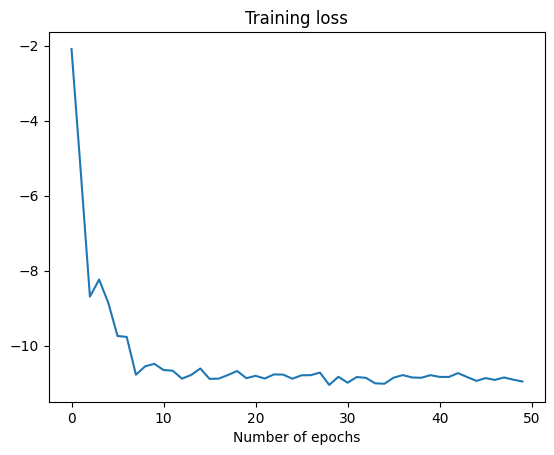

In [110]:
plt.plot(objective_func_vals)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [111]:
y_test_pred = classifier.predict(x_test)
# y_test_pred

In [112]:
classifier.score(x_train, new_y_train)

0.6890130353817505

In [113]:
classifier.score(x_test, new_y_test)

0.658008658008658